Example 9.8 (Gelman-Rubin method of monitoring convergence)
This example illustrates the Gelman-Rubin method of monitoring convergenceof a Metropolis chain. 
The target distribution is Normal(0,1), and the proposal distribution is Normal(Xt, σ2). 
The scalar summary statistic ψij is themean of the ith chain up to time j. 
After generating all chains the diagnosticstatistics are computed in the Gelman.Rubin function below.

In [1]:
using Statistics
using Plots

In [2]:
function gelman_rubin(psi::AbstractMatrix{<:Real})
    # psi[i, j] represents the statistic psi(X[i, 1:j]) for the i-th chain at the j-th step.
    
    n = size(psi, 2)  # Number of steps per chain (length of each chain)
    k = size(psi, 1)  # Number of chains

    # Compute the mean of each chain (mean along rows, resulting in a vector of sample means for each chain)
    chain_means = dropdims(mean(psi, dims=2), dims=2)  # Remove singleton dimension, resulting in a vector of length k

    # Compute the between-chain variance B: B = n * Var(mean of each chain)
    B = n * var(chain_means)

    # Compute the sample variance of each chain (within-chain variance), then take the average W
    chain_vars = dropdims(var(psi, dims=2), dims=2)  # Vector of sample variances for each chain
    W = mean(chain_vars)  # Average of within-chain variances

    # Estimate the total variance v_hat, combining both within-chain and between-chain variability
    v_hat = ((n - 1) / n) * W + (B / n)

    # Gelman-Rubin statistic R_hat is defined as √(v_hat / W)
    return sqrt(v_hat / W)
end

gelman_rubin (generic function with 1 method)

In [3]:
function normal_chain(sigma::Real, N::Integer, X1::Real)
    # Generate a Metropolis chain for the target distribution N(0,1)
    # Proposal distribution is N(X[t], sigma)
    
    x = Vector{Float64}(undef, N)  # Initialize a vector to store the chain
    x[1] = X1                      # Set the initial value

    for i in 2:N
        xt = x[i - 1]              # Current state
        y = xt + sigma * randn()   # Generate candidate point y ~ N(xt, sigma)
        
        # Compute the acceptance ratio r
        # Since the target density is N(0,1), its density function ratio is exp(-0.5 * x^2)
        # Therefore, the ratio of the candidate point to the current state is exp(-0.5*(y^2 - xt^2))
        r = exp(-0.5 * (y^2 - xt^2))
        
        # Accept the candidate point with probability min(1, r)
        # Use rand() to generate a uniform random number in [0,1] for comparison
        if rand() <= r
            x[i] = y  # Accept the candidate point
        else
            x[i] = xt # Retain the current state
        end
    end

    return x
end

normal_chain (generic function with 1 method)

In [4]:
# Parameter settings
sigma = 0.2         # Standard deviation parameter for the proposal distribution
k = 4               # Number of MCMC chains
n = 15000           # Number of steps per chain (chain length)
b = 1000            # Burn-in steps

# Set initial values for each chain
x0 = [-10, -5, 5, 10]

# Generate k chains: each chain is created using normal_chain(sigma, n, x0[i])
chains = [normal_chain(sigma, n, x0[i]) for i in 1:k]

# Convert the generated chains into a k x n matrix (each row represents a chain)
X = hcat(chains...)'

# Compute the cumulative sum and normalize to obtain the cumulative mean ψ
# psi[i, j] represents the cumulative mean of the first j steps of the i-th chain
psi = cumsum(X, dims=2) ./ reshape(1:n, 1, :)

# Compute the Gelman-Rubin statistic
r_hat = gelman_rubin(psi)
println("Gelman-Rubin R-hat: ", r_hat)

Gelman-Rubin R-hat: 1.0828914427417675


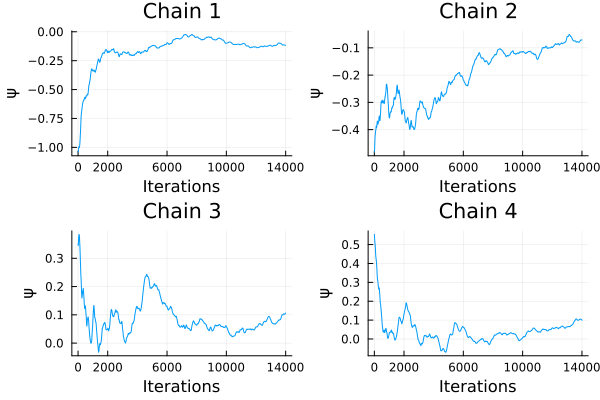

In [5]:
# Define x-axis tick positions and corresponding labels
xticks_values = [0, 2000, 6000, 10000, 14000]
xticks_tuple = (xticks_values, string.(xticks_values))  # Tick positions and labels

# Create a 2x2 plotting layout
p = plot(layout = (2, 2))

# Iterate through each chain and plot the evolution of ψ over iterations
for i in 1:k
    # Select data from the (b + 1)th step to the nth step for the i-th chain
    chain_data = psi[i, (b + 1):n]
    
    # Plot the curve for the current chain
    plot!(p,
          chain_data,
          label = "",
          xlabel = "Iterations",
          ylabel = "ψ",
          xticks = xticks_tuple,
          subplot = i,
          title = "Chain $i")  # Add a title for each subplot
end

display(p)

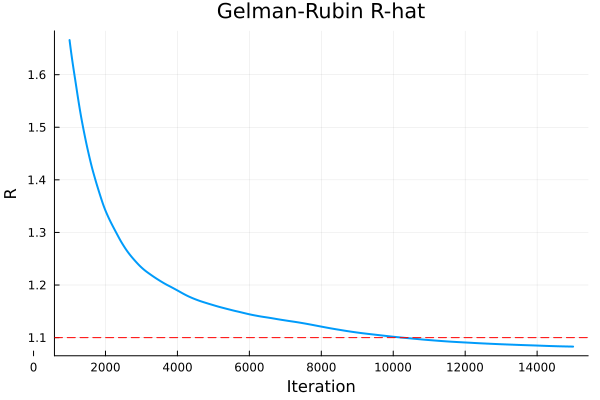

In [6]:
# Compute the Gelman-Rubin R-hat statistic at each step (starting from step b+1)
# Use list comprehension to generate the sequence of R-hat values
r_hat_series = [gelman_rubin(psi[:, 1:j]) for j in b+1:n]

# Define the corresponding iteration steps as x-axis values
iterations = b+1:n

# Define x-axis tick positions and labels
xticks_values = [0, 2000, 4000, 6000, 8000, 10000, 12000, 14000]
xticks_tuple = (xticks_values, string.(xticks_values))

# Plot the evolution of the R-hat statistic over iterations
plot(iterations, r_hat_series,
     xlabel = "Iteration",
     ylabel = "R",
     title = "Gelman-Rubin R-hat",
     linewidth = 2,
     legend = false,
     xticks = xticks_tuple)

# Add a reference line at R = 1.1 (dashed red line)
hline!([1.1], linestyle = :dash, color = :red, label = "")

Example 9.9 (Coal mining disasters)
In the coal data, the date of the disaster is given. 
The integer part of thedate gives the year. For simplicity truncate the fractional part of the year.
As a first step, tabulate the number of disasters per year and create a time plot.

First, output and save the coal dataset from the boot library in R as coal.csv (included in the compressed file). To ensure that the analysis in Julia reproduces the same results as in R, this code is based on coal.csv.

In [7]:
using CSV
using DataFrames
using Plots
using StatsBase
using Random
using Distributions

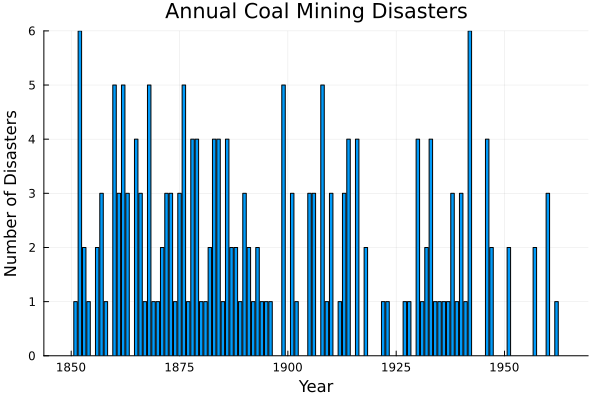

In [8]:
# Read the CSV file
coal_data = CSV.read("/Users/alan/Desktop/统计计算/第一次作业/coal.csv", DataFrame)

# Extract years and apply floor function
years = floor.(coal_data.date)

# Count the number of disasters per year (similar to the `table` function in R)
year_counts = countmap(years)
df = DataFrame(Year=sort(collect(keys(year_counts))), Count=collect(values(year_counts)))

# Plot the time series
plot(df.Year, df.Count, seriestype=:bar, xlabel="Year", ylabel="Number of Disasters",
     title="Annual Coal Mining Disasters", legend=false)

In [9]:
# Extract years and count the number of disasters
years = floor.(coal_data.date)
year_counts = countmap(Int.(years))  # Count the number of disasters per year
y = [get(year_counts, year, 0) for year in minimum(years):maximum(years)]  # Fill in missing years

112-element Vector{Int64}:
 4
 5
 4
 1
 0
 4
 3
 4
 0
 6
 3
 3
 4
 ⋮
 1
 0
 0
 0
 0
 0
 1
 0
 0
 1
 0
 1

In [10]:
# Gibbs sampling initialization
n = length(y)  # Length of the data
m = 1000  # Length of the Markov chain
mu = zeros(Float64, m)
lambda = zeros(Float64, m)
k = zeros(Int, m)
L = zeros(Float64, n)
k[1] = rand(1:n)  # Randomly initialize k
mu[1] = 1.0
lambda[1] = 1.0
b1 = 1.0
b2 = 1.0

# Run the Gibbs sampler
for i in 2:m
    kt = k[i - 1]
    
    # Sample mu
    r = 0.5 + sum(y[1:kt])
    mu[i] = rand(Gamma(r, 1 / (kt + b1)))
    
    # Sample lambda
    if kt + 1 > n
        r = 0.5 + sum(y)
    else
        r = 0.5 + sum(y[(kt + 1):n])
    end
    lambda[i] = rand(Gamma(r, 1 / (n - kt + b2)))
    
    b1 = rand(Gamma(0.5, 1 / (mu[i] + 1)))
    b2 = rand(Gamma(0.5, 1 / (lambda[i] + 1)))
    
    # Compute likelihood
    for j in 1:n
        L[j] = exp((lambda[i] - mu[i]) * j) * (mu[i] / lambda[i])^sum(y[1:j])
    end
    
    L ./= sum(L)  # Normalize
    dist = Categorical(L)  # Define a discrete distribution based on L
    k[i] = rand(dist)  # Sample k based on probability distribution
end

b = 201  # Burn-in period
post_k = k[b:end]
post_mu = mu[b:end]
post_lambda = lambda[b:end]

println("Posterior mean of k: ", mean(post_k))
println("Posterior mean of μ: ", mean(post_mu))
println("Posterior mean of λ: ", mean(post_lambda))

Posterior mean of k: 39.93
Posterior mean of μ: 3.123637049488224
Posterior mean of λ: 0.9312306958851372


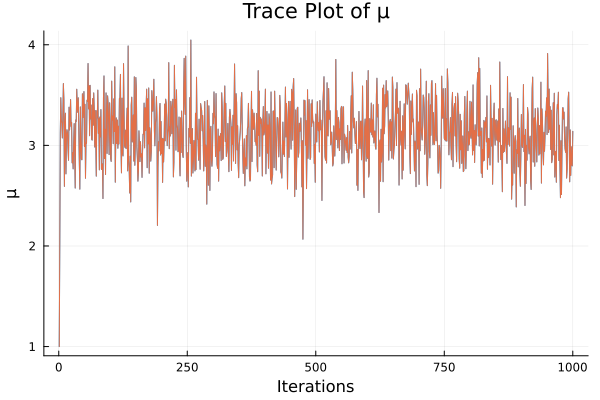

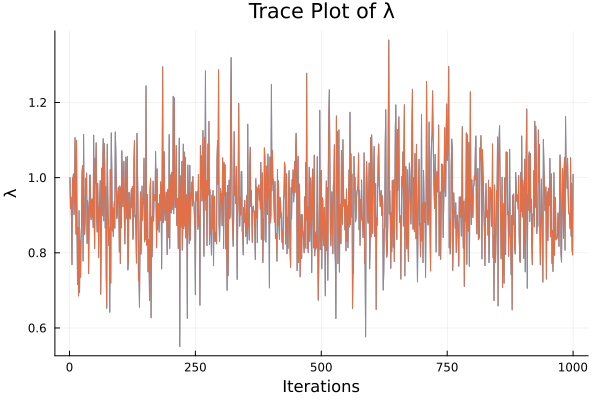

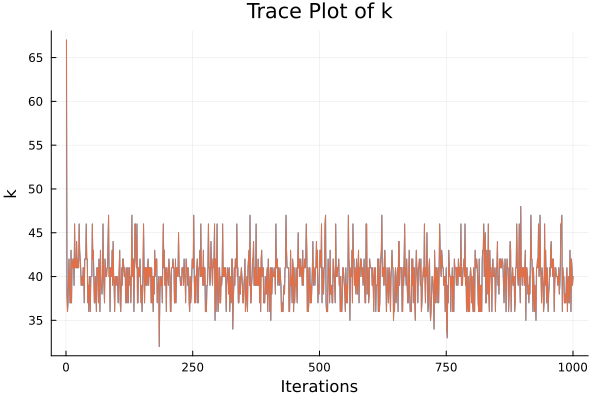

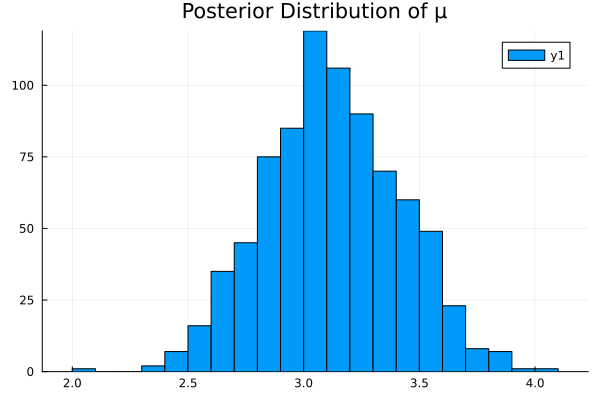

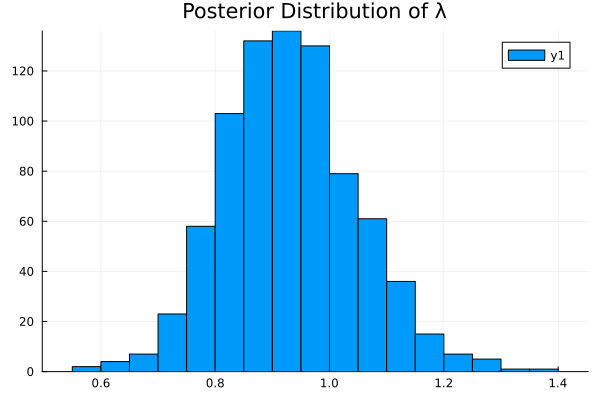

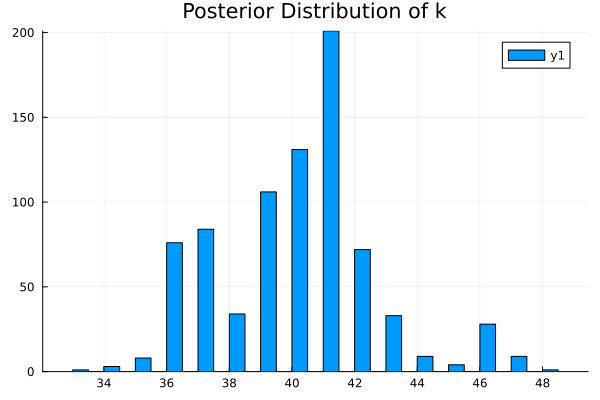

In [11]:
# Trace plots
plot(1:m, mu, label="μ", xlabel="Iterations", ylabel="μ", title="Trace Plot of μ")
display(plot!(1:m, mu, label="", legend=false))  # Display the trace plot of μ

plot(1:m, lambda, label="λ", xlabel="Iterations", ylabel="λ", title="Trace Plot of λ")
display(plot!(1:m, lambda, label="", legend=false))  # Display the trace plot of λ

plot(1:m, k, label="k", xlabel="Iterations", ylabel="k", title="Trace Plot of k")
display(plot!(1:m, k, label="", legend=false))  # Display the trace plot of k

# Posterior distribution plots
histogram(post_mu, bins=30, title="Posterior Distribution of μ", xlabel="μ", ylabel="Density", normalize=true)
display(histogram(post_mu, bins=30, title="Posterior Distribution of μ"))

histogram(post_lambda, bins=30, title="Posterior Distribution of λ", xlabel="λ", ylabel="Density", normalize=true)
display(histogram(post_lambda, bins=30, title="Posterior Distribution of λ"))

histogram(post_k, bins=30, title="Posterior Distribution of k", xlabel="k", ylabel="Density", normalize=true)
display(histogram(post_k, bins=30, title="Posterior Distribution of k"))